# Prevendo Customer Churn em Operadoras de Telecom

![title](photo.jpeg)

## Problema de negócio

Customer Churn refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Ou seja, para a empresa, refere-se à perda de clientes e é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, farei a previsão de Customer Churn em uma Operadora de Telecom. Criarei um modelo de aprendizagem de máquina capaz de prever se um cliente pode ou não cancelar seu plano e qual a probabilidade de isso ocorrer.

# <font color='grey'>Análise Exploratória</font>

In [2]:
# Importação das bibliotecas:

# Manipulação de dados.
import pandas as pd
import numpy as np

# Visualização.
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de dados.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Machine Learning.
from sklearn.linear_model import LogisticRegression

# Métricas de avaliação do modelo preditivo.
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Ignorar mensagens de aviso.
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Leitura dos arquivos e instanciar os datasets:
df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8")
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8")

In [4]:
# Dimensões dos datasets:
print("Dimesão do dataset de treino:\nLinhas: {}\nColunas: {}".format(df_train.shape[0], df_train.shape[1]))
print("Dimesão do dataset de teste:\nLinhas: {}\nColunas: {}".format(df_test.shape[0], df_test.shape[1]))

Dimesão do dataset de treino:
Linhas: 3333
Colunas: 21
Dimesão do dataset de teste:
Linhas: 1667
Colunas: 21


In [5]:
# Visualizando as primeiras linhas:
df_train.head(3)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no


#### Análise da representatividade das variáveis

Percebo que os nomes das variáveis são bastante sugestivos. Por isso, agora analisarei o que elas representam.

In [6]:
df_train.columns

Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

Ao analisar os nomes das variáveis, acredito que essa base traga dados de cadastro do cliente assim como dados sobre o seu comportamento.

**Dados do cliente:**

'state' 

'account_length'

'area_code'

'international_plan'

'voice_mail_plan'

**Dados de comportamento do cliente:**

'number_vmail_messages'

'total_day_minutes'

'total_day_calls'

'total_day_charge'

'total_eve_minutes'

'total_eve_calls'

'total_eve_charge'

'total_night_minutes'

'total_night_calls'

'total_night_charge'

'total_intl_minutes'

'total_intl_calls'

'total_intl_charge'

'number_customer_service_calls'

In [7]:
# Proporção de churn
df_train.groupby('churn').size()

churn
no     2850
yes     483
dtype: int64

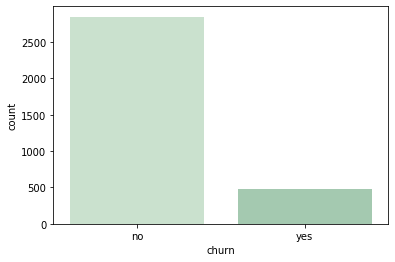

In [8]:
sns.countplot(df_train.churn, palette = sns.color_palette("ch:2.5,-.2,dark=.3"))

In [9]:
print("Porcentagem de clientes que não cancelaram: {} %".format(round(df_train[df_train["churn"]=="no"].shape[0]/df_train.shape[0],2)*100))
print("Porcentagem de clientes que cancelaram: {} %".format(round(df_train[df_train["churn"]=="yes"].shape[0]/df_train.shape[0],2)*100))

Porcentagem de clientes que não cancelaram: 86.0 %
Porcentagem de clientes que cancelaram: 14.000000000000002 %


Aqui percebo que as classes da variável target estão desbalanceadas - há uma predominâcia de clientes que não cancelaram o seu plano (86%) e isso pode fazer com que o modelo preditivo aprenda muito sobre essa classe e não consiga fazer boas previsões sobre a classe dos clientes que cancelam o plano. Portanto, precisarei usar técnicas para o balanceamento dessa classe.

#### Análise das variáveis

Aqui visualizarei a natureza das variáveis intepretada pela linguagem python.

In [10]:
df_types = pd.DataFrame({'data_type': df_train.dtypes})

In [11]:
df_types 

,data_type
Unnamed: 0,int64
state,object
account_length,int64
area_code,object
international_plan,object
voice_mail_plan,object
number_vmail_messages,int64
total_day_minutes,float64
total_day_calls,int64
total_day_charge,float64


In [12]:
df_train.describe()

,Unnamed: 0,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.00000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,1667.00000,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,962.29855,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,834.00000,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,1667.00000,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,2500.00000,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,3333.00000,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


#### Verificar colineariedade

Agora vejo a correlação entre as variáveis para verificar se há caso de colineridade.

In [13]:
df_train.corr()

,Unnamed: 0,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
Unnamed: 0,1.000000,0.036667,-0.018086,-0.020769,0.000272,-0.020769,0.013872,0.009149,0.013875,0.011295,0.000995,0.011311,0.005822,-0.011221,0.005780,0.009665
account_length,0.036667,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
number_vmail_messages,-0.018086,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
total_day_minutes,-0.020769,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
total_day_calls,0.000272,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
total_day_charge,-0.020769,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
total_eve_minutes,0.013872,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
total_eve_calls,0.009149,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
total_eve_charge,0.013875,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
total_night_minutes,0.011295,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288


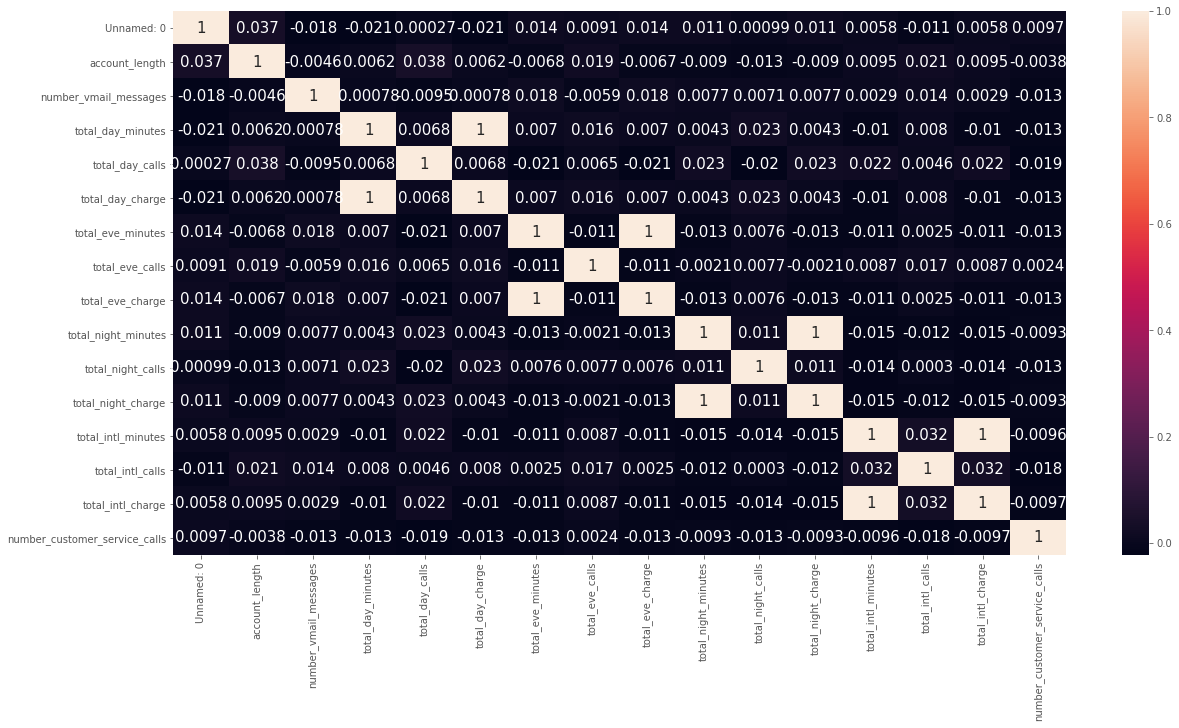

In [14]:
# Verificar correlações de features selecionadas:
plt.style.use('ggplot')
corr = df_train.corr()
ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr,  annot=True, annot_kws={"size": 15})

Pelo quadro e gráfico acima, percebo variáveis totalmente colineares, ou seja, tais variáveis estão representando a exatamente a mesma informação e são elas:
1. 'total_day_charge' e 'total_day_minutes'
2. 'total_eve_charge' e 'total_eve_minutes'
3. 'total_night_charge' e 'total_night_minutes'
4. 'total_intl_charge' e 'total_intl_minutes'

Já que tais pares de variáveis estão representando a mesma informação, eliminarei uma de cada par. Escolho por eliminar tota_x_charge.

#### Verificar dados missing

In [15]:
# Verificar a quantidade de valores não preenchidos dentro das features selecionadas:
df_train.isnull().sum()

Unnamed: 0                       0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

Ótimo, não há dados faltantes!

**Clonclusões da Análise Exploratória:**
1. A variável target está desbalanceada
2. Há colineariedade entre variáveis
3. A base de dados não apresenta dados faltantes

# <font color='grey'>Pré-processamento dos dados</font>

#### Tranformação 1: deletar variáveis irrelevantes

In [16]:
df_train_1 = df_train.copy()

In [17]:
# Deletar as variáveis que representam códigos:
df_train_1 = df_train.drop(['Unnamed: 0', 'area_code'], axis = 1)
print("Atualizando: \nNúmero de variáveis no dataset de treino: {}".format(df_train_1.shape[1]))

Atualizando: 
Número de variáveis no dataset de treino: 19


#### Transformação 2: codificar as variáveis:

In [18]:
df_types[df_types['data_type'] == "object"]

,data_type
state,object
area_code,object
international_plan,object
voice_mail_plan,object
churn,object


São 3 variáveis, além da variável target, que estão classificadas como objeto e preciso codificá-las para que o modelo as entenda.

In [20]:
df_train_1.state.unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [21]:
df_train_1.international_plan.unique()

array(['no', 'yes'], dtype=object)

In [22]:
df_train_1.voice_mail_plan.unique()

array(['yes', 'no'], dtype=object)

In [23]:
df_train_2 = df_train_1.copy()
df_test_1 = df_test.copy()

In [24]:
# Alterando os dados do tipo "yes" ou "no" para binários:
df_train_2 = df_train_1.replace({"yes": 1, "no":0})
# Nesse caso, também é preciso fazer a alteração no dataset de teste
df_test_1 = df_test.replace({"yes": 1, "no":0})

In [25]:
# Codificar a variável estado
encoder = LabelEncoder()
df_train_2["cod_state"] = encoder.fit_transform(df_train_2.state)
df_test_1["cod_state"] = encoder.fit_transform(df_test_1.state)

#### Tranformação 3: eliminar variáveis colineares

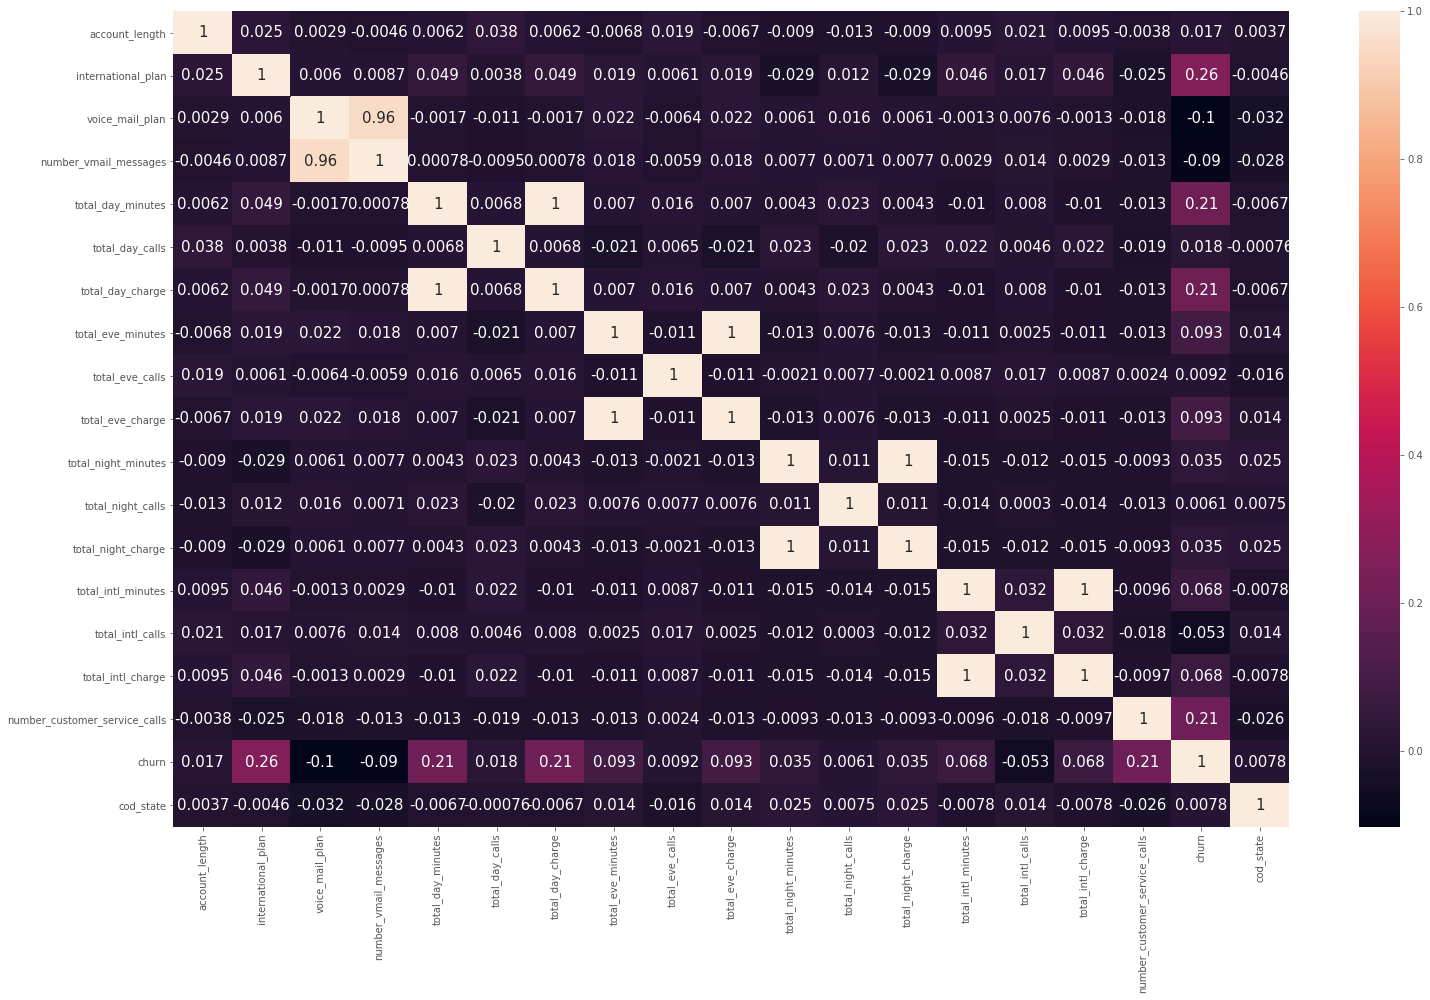

In [26]:
# Verificar correlações de features selecionadas agora com as variáveis codificadas:
plt.style.use('ggplot')
corr = df_train_2.corr()
ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr,  annot=True, annot_kws={"size": 15})

Além das variáveis colineares identificadas na análise exploratória, aqui identifico mais 2 variáveis altamente colineares:

'voice_mail_plan' e 'number_vmail_messages'

Decido por eliminar 'number_vmail_messages'.

In [27]:
df_train_3 = df_train_2.copy()

In [28]:
# Deletar as variáveis colideares.
df_train_3 = df_train_2.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge','number_vmail_messages'], axis = 1)
print("Atualizando: \nNúmero de variáveis no dataset de treino: {}".format(df_train_3.shape[1]))

Atualizando: 
Número de variáveis no dataset de treino: 15


# <font color='purple'>Feature Selection</font>

In [29]:
# Analisando a correlação das variáveis com a variável target
df_corr = df_train_3.corr()

In [30]:
df_corr

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn,cod_state
account_length,1.000000,0.024735,0.002918,0.006216,0.038470,-0.006757,0.019260,-0.008955,-0.013176,0.009514,0.020661,-0.003796,0.016541,0.003678
international_plan,0.024735,1.000000,0.006006,0.049396,0.003755,0.019100,0.006114,-0.028905,0.012451,0.045871,0.017366,-0.024522,0.259852,-0.004597
voice_mail_plan,0.002918,0.006006,1.000000,-0.001684,-0.011086,0.021545,-0.006444,0.006079,0.015553,-0.001318,0.007618,-0.017824,-0.102148,-0.031664
total_day_minutes,0.006216,0.049396,-0.001684,1.000000,0.006750,0.007043,0.015769,0.004323,0.022972,-0.010155,0.008033,-0.013423,0.205151,-0.006737
total_day_calls,0.038470,0.003755,-0.011086,0.006750,1.000000,-0.021451,0.006462,0.022938,-0.019557,0.021565,0.004574,-0.018942,0.018459,-0.000764
total_eve_minutes,-0.006757,0.019100,0.021545,0.007043,-0.021451,1.000000,-0.011430,-0.012584,0.007586,-0.011035,0.002541,-0.012985,0.092796,0.013682
total_eve_calls,0.019260,0.006114,-0.006444,0.015769,0.006462,-0.011430,1.000000,-0.002093,0.007710,0.008703,0.017434,0.002423,0.009233,-0.016268
total_night_minutes,-0.008955,-0.028905,0.006079,0.004323,0.022938,-0.012584,-0.002093,1.000000,0.011204,-0.015207,-0.012353,-0.009288,0.035493,0.024576
total_night_calls,-0.013176,0.012451,0.015553,0.022972,-0.019557,0.007586,0.007710,0.011204,1.000000,-0.013605,0.000305,-0.012802,0.006141,0.007458
total_intl_minutes,0.009514,0.045871,-0.001318,-0.010155,0.021565,-0.011035,0.008703,-0.015207,-0.013605,1.000000,0.032304,-0.009640,0.068239,-0.007834


Considerarei apenas as variáveis que tenham força de relação de pelo menos 0.1 nas direções positiva e negativa com a variável target.

In [31]:
df_corr[df_corr["churn"]>0.1]

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn,cod_state
international_plan,0.024735,1.000000,0.006006,0.049396,0.003755,0.019100,0.006114,-0.028905,0.012451,0.045871,0.017366,-0.024522,0.259852,-0.004597
total_day_minutes,0.006216,0.049396,-0.001684,1.000000,0.006750,0.007043,0.015769,0.004323,0.022972,-0.010155,0.008033,-0.013423,0.205151,-0.006737
number_customer_service_calls,-0.003796,-0.024522,-0.017824,-0.013423,-0.018942,-0.012985,0.002423,-0.009288,-0.012802,-0.009640,-0.017561,1.000000,0.208750,-0.025861
churn,0.016541,0.259852,-0.102148,0.205151,0.018459,0.092796,0.009233,0.035493,0.006141,0.068239,-0.052844,0.208750,1.000000,0.007780


In [32]:
df_corr[df_corr["churn"]<-0.1]

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn,cod_state
voice_mail_plan,0.002918,0.006006,1.0,-0.001684,-0.011086,0.021545,-0.006444,0.006079,0.015553,-0.001318,0.007618,-0.017824,-0.102148,-0.031664


In [33]:
# Considero então 4 variáveis:
features = ['international_plan', 'total_day_minutes', 'number_customer_service_calls', 'voice_mail_plan']

#### Análise das variáveis selecionadas

Percebe-se que a possibilidade de Customer Churn está relacionado a:
- **'international_plan'**: Se o cliente tem ou não plano internacional
- **'voice_mail_plan'**: Se o cliente possui o recurso de correio de voz
- **'total_day_minutes'**: Quanto tempo o cliente gasta nas ligações por dia
- **'number_customer_service_calls'**: O número de vezes que o cliente precisou solicitar serviços por ligação

# <font color='grey'>Modelo preditivo</font>

#### Primeiro modelo: modelo_1

In [34]:
# Definir as variáveis de entrada e saída para o treinamento do modelo e as variáveis de entrada para teste:
y_train_1 = df_train_3.churn
x_train_1 = df_train_3[features]
x_test_1 = df_test_1[features]
y_test_1 = df_test_1.churn

In [35]:
# Criação do modelo
modelo_1 = LogisticRegression()

# Treinamento do modelo
modelo_1.fit(x_train_1, y_train_1)

LogisticRegression()

In [36]:
# Score do modelo com os dados de teste
result = modelo_1.score(x_test_1, y_test_1)
print("Acurácia nos Dados de teste do modelo_1: %.3f%%" % (result * 100.0))

Acurácia nos Dados de teste do modelo_1: 86.863%


Essa acurácia pode ser um falso indicador de performance. Isso porque o **modelo_1** foi criado com a vaiável target desbalanceada. Então, pode acontecer de o modelo ter aprendido muito sobre uma classe e pouco sobre outra e, como ele aprendeu bem a classe que predomina nos dados de teste, a acurácia sinalizará boa performance.

Olharei então para outras métricas:

In [37]:
y_pred_1 = modelo_1.predict(x_test_1)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1443
           1       0.54      0.16      0.24       224

    accuracy                           0.87      1667
   macro avg       0.71      0.57      0.59      1667
weighted avg       0.84      0.87      0.84      1667



De fato, no relatório acima, percebe-se que o modelo aprendeu bem sobre a classe 0, mas não sobre a classe 1.

Vou deixar ainda mais claro.

In [39]:
df_compara_1 = pd.DataFrame({'predições': y_pred_1, 'valor_real': y_test_1})

In [43]:
# Dataframes que mostram quando as predições acertaram a classe 1 e 0 no modelo_1
df_1_pred1 = df_compara_1.loc[(df_compara_1['predições'] == 1) & (df_compara_1['valor_real'] == 1)]
df_1_pred0 = df_compara_1.loc[(df_compara_1['predições'] == 0) & (df_compara_1['valor_real'] == 0)]

In [44]:
print("O modelo_1 acerta: {}% da classe 1".format(round(df_1_pred1.shape[0]/df_compara_1[df_compara_1['valor_real'] ==1].shape[0],2)*100))
print("O modelo_1 acerta: {}% da classe 0".format(round(df_1_pred0.shape[0]/df_compara_1[df_compara_1['valor_real'] ==0].shape[0],2)*100))

O modelo_1 acerta: 16.0% da classe 1
O modelo_1 acerta: 98.0% da classe 0


Agora o overfitting fica evidente! 

#### Segundo modelo: modelo_2
Mudança: balancear a variável target

Como mostrou a análise exploratória, a variável target estava desbalanceada. Para balancear, uasarei a técnica over-sampling.

In [45]:
print("Porcentagem de clientes que não cancelaram: {} %".format(round(df_train_3[df_train_3["churn"]==1].shape[0]/df_train_3.shape[0],2)*100))
print("Porcentagem de clientes que cancelaram: {} %".format(round(df_train_3[df_train_3["churn"]==0].shape[0]/df_train_3.shape[0],2)*100))

Porcentagem de clientes que não cancelaram: 14.000000000000002 %
Porcentagem de clientes que cancelaram: 86.0 %


In [46]:
df_train_4 = df_train_3.copy()

In [47]:
X = df_train_3[features]
y = df_train_3.churn
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

df_train_4 = pd.concat([X_resampled, y_resampled], axis=1)

In [52]:
print("Para balancear a variável target, foram criados {} dados sintéticos.".format(df_train_4.shape[0] - df_train_3.shape[0]))

Para balancear a variável target, foram criados 2367 dados sintéticos.


In [53]:
# Dados balanceados
print("Porcentagem de clientes que não cancelaram: {} %".format(round(df_train_4[df_train_4["churn"]==1].shape[0]/df_train_4.shape[0],2)*100))
print("Porcentagem de clientes que cancelaram: {} %".format(round(df_train_4[df_train_4["churn"]==0].shape[0]/df_train_4.shape[0],2)*100))

Porcentagem de clientes que não cancelaram: 50.0 %
Porcentagem de clientes que cancelaram: 50.0 %


Importante notar aqui: não se deve balancear a variável target nos dados de teste. Os dados de teste representam a ralidade que o modelo irá enfrentar, ou seja, é muito provável que ele receberá dados desbalanceados e é esperado que ele saiba prever bem as duas classes nessa situação. Para isso, o modelo precisa aprender sobre ambas as classes da variável target, por isso balancear os dados de treino.

In [54]:
# dados de entrada e saída
y_train_2 = df_train_4.churn
x_train_2 = df_train_4[features]
y_test_2 = df_test_1.churn
x_test_2 = df_test_1[features]

modelo_2 = LogisticRegression()
modelo_2.fit(x_train_2, y_train_2)

LogisticRegression()

In [55]:
result = modelo_2.score(x_test_2, y_test_2)
print("Acurácia nos Dados de teste do modelo_2: %.3f%%" % (result * 100.0))

Acurácia nos Dados de teste do modelo_2: 69.106%


Aqui percebe-se que balancear a variável target piorou a acurácia do modelo, mas isso não significa que piorou a performance como explicado acima.

In [56]:
y_pred_2 = modelo_2.predict(x_test_2)

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1443
           1       0.28      0.84      0.42       224

    accuracy                           0.69      1667
   macro avg       0.62      0.75      0.61      1667
weighted avg       0.87      0.69      0.74      1667



Aqui já se percebe que a performance melhorou, deixarei mais claro.

In [58]:
df_compara_2 = pd.DataFrame({'predições': y_pred_2, 'valor_real': y_test_2})

In [59]:
# Dataframes que mostram quando as predições acertaram a classe 1 nos modelos 1 e 2 
df_2_pred1 = df_compara_2.loc[(df_compara_2['predições'] == 1) & (df_compara_2['valor_real'] == 1)]
df_2_pred0 = df_compara_2.loc[(df_compara_2['predições'] == 0) & (df_compara_2['valor_real'] == 0)]

In [60]:
print("O modelo_2 acerta: {}% da classe 1".format(round(df_2_pred1.shape[0]/df_compara_1[df_compara_1['valor_real'] ==1].shape[0],2)*100))
print("O modelo_2 acerta: {}% da classe 0".format(round(df_2_pred0.shape[0]/df_compara_1[df_compara_1['valor_real'] ==0].shape[0],2)*100))

O modelo_2 acerta: 84.0% da classe 1
O modelo_2 acerta: 67.0% da classe 0


Balancear a variável target fez o modelo melhorar ao prever a classe 1, mas piorar ao prever a classe 0. Então eu analiso o impacto que cada um desses modelos podem causar na prática:

**modelo_1**: Modelo que não preve bem a classe 1, logo ele não consegue identificar com precisão os clientes propícios ao churn. Ou seja, ele não resolve o problema para o qual foi proposto.

**modelo_2**: Modelo que preve bem a classe 1, mas não tão bem a classe 0. Esse modelo fará boas previsões de clientes propícios ao churn. Mas o modelo vai errar mais em sinalizar clientes propícios ao churn quando na verdade não são. Nesse caso, o que pode acontecer é envolver clientes em campanhas de marketing, quando na verdade eles não precisariam ser envolvidos. Isso pode gerar um custo desnecessário, mas dependendo da estratégia do merketing, esse custo pode ser compensado pela retenção de clientes.

Assim, eu descarto o modelo_1 e tento melhorar o modelo_2.


#### Terceiro modelo: modelo_3
Mudança: target balanceada + deixar os dados na mesma escala

In [61]:
df_train_5 = df_train_4.copy()
df_test_2 = df_test_1.copy()

In [62]:
# Transformando os dados para a mesma escala (entre 0 e 1) as variáveis numéricas
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX_train = scaler.fit_transform(df_train_5[features])
# Aqui preciso alterar os dados de teste também
rescaledX_test = scaler.fit_transform(df_test_1[features])

In [63]:
rescaledX_train

array([[0.        , 0.75570125, 0.11111111, 1.        ],
       [0.        , 0.46066135, 0.11111111, 1.        ],
       [0.        , 0.69384265, 0.        , 0.        ],
       ...,
       [0.        , 0.17217137, 0.33333333, 0.        ],
       [0.        , 0.4774406 , 0.        , 0.        ],
       [1.        , 0.49343198, 0.        , 0.        ]])

In [64]:
df_train_5['total_day_minutes'] = rescaledX_train[:,1]
df_train_5['number_customer_service_calls'] = rescaledX_train[:,2]

In [65]:
df_train_5[features].head(2)

,international_plan,total_day_minutes,number_customer_service_calls,voice_mail_plan
0,0,0.755701,0.111111,1
1,0,0.460661,0.111111,1


In [66]:
df_test_2['total_day_minutes'] = rescaledX_test[:,1]
df_test_2['number_customer_service_calls'] = rescaledX_test[:,2]

In [67]:
df_test_2[features].head(2)

,international_plan,total_day_minutes,number_customer_service_calls,voice_mail_plan
0,0,0.186431,0.428571,0
1,0,0.629168,0.000000,0


In [68]:
# Dados para o modelo
y_train_3 = df_train_5.churn
x_train_3 = df_train_5[features]
y_test_3 = df_test_2.churn
x_test_3 = df_test_2[features]

modelo_3 = LogisticRegression()
modelo_3.fit(x_train_3, y_train_3)

LogisticRegression()

In [69]:
result = modelo_3.score(x_test_3, y_test_3)
print("Acurácia nos Dados de teste: %.3f%%" % (result * 100.0))

Acurácia nos Dados de teste: 65.147%


In [70]:
y_pred_3 = modelo_3.predict(x_test_3)
print(classification_report(y_test_3, y_pred_3))

              precision    recall  f1-score   support

           0       0.97      0.62      0.75      1443
           1       0.26      0.88      0.40       224

    accuracy                           0.65      1667
   macro avg       0.62      0.75      0.58      1667
weighted avg       0.88      0.65      0.71      1667



Deixar os dados todos na mesma escala não melhorou a performance.

#### Quarto modelo: modelo_4

Mudança: target balanceada + otimização de parametros

# <font color='grey'>Resultado Final</font>

In [71]:
probabilidades = modelo_2.predict_proba(x_test_2)

In [72]:
df_resposta = pd.DataFrame({'predições': y_pred_2, 'prob. de não churn (0) (%)': probabilidades[:,0]*100, 'prob. de churn (1) (%)': probabilidades[:,1]*100, 'valor_real':y_test_2})


In [73]:
df_resposta

,predições,prob. de não churn (0) (%),prob. de churn (1) (%),valor_real
0,0,69.682782,30.317218,0
1,0,53.923276,46.076724,0
2,0,64.275659,35.724341,0
3,1,45.669832,54.330168,0
4,1,41.442266,58.557734,0
5,1,42.655704,57.344296,0
6,0,82.387498,17.612502,0
7,0,72.917870,27.082130,0
8,0,73.486232,26.513768,0
9,0,92.255014,7.744986,0


Aqui uma possibilidade seria selecionar os clientes de diferentes faixas de probabilidade de churn. Por exemplo, criar campanhas para quem está na faixa de probabilidade de 50-70%, outra campanha para a faixa de 70-90% e uma forte campanha para os clientes na faixa acima de 90%.

Porém, antes ainda, eu precisaria encontrar maneiras de melhorar a performance do modelo. Acredito que o modelo acertando numa faixa de 90% para ambas as classes já seria satisfatório para esse problema de negócio.

Aceito sugestões para melhorar a performance desse modelo :)